In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

In [ ]:

%%html
<style>
.container {width: 90% !important; }
#logo
{
    float: left;
}
#names
{
    float: right;
    
}
#logo2
{
    float: right;
    height=100;
    width=100;
    margin: 5px;
}
#top_menu
{
    margin: 20px auto 0;
    
    height:300px;
    width: 400px;
}
</style>

## ArcGIS API for Python: Advanced Scripting
<img src="ben.jpg"/>
Ben Hammersley (BHammersley@esriuk.com) | Solution Engineer with Esri UK

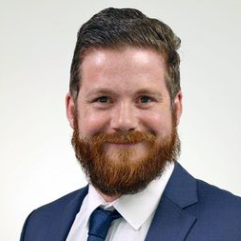
Philippe Rieffel (p.rieffel@esri.de) | Consultant with Esri Germany

## Part 1: The gis & features modules
+ python API offers easy access to users, groups, content, licenses
+ analyze the state of your Portal
+ automate recurring administration tasks
+ have supported ways to transfer stuff between portals

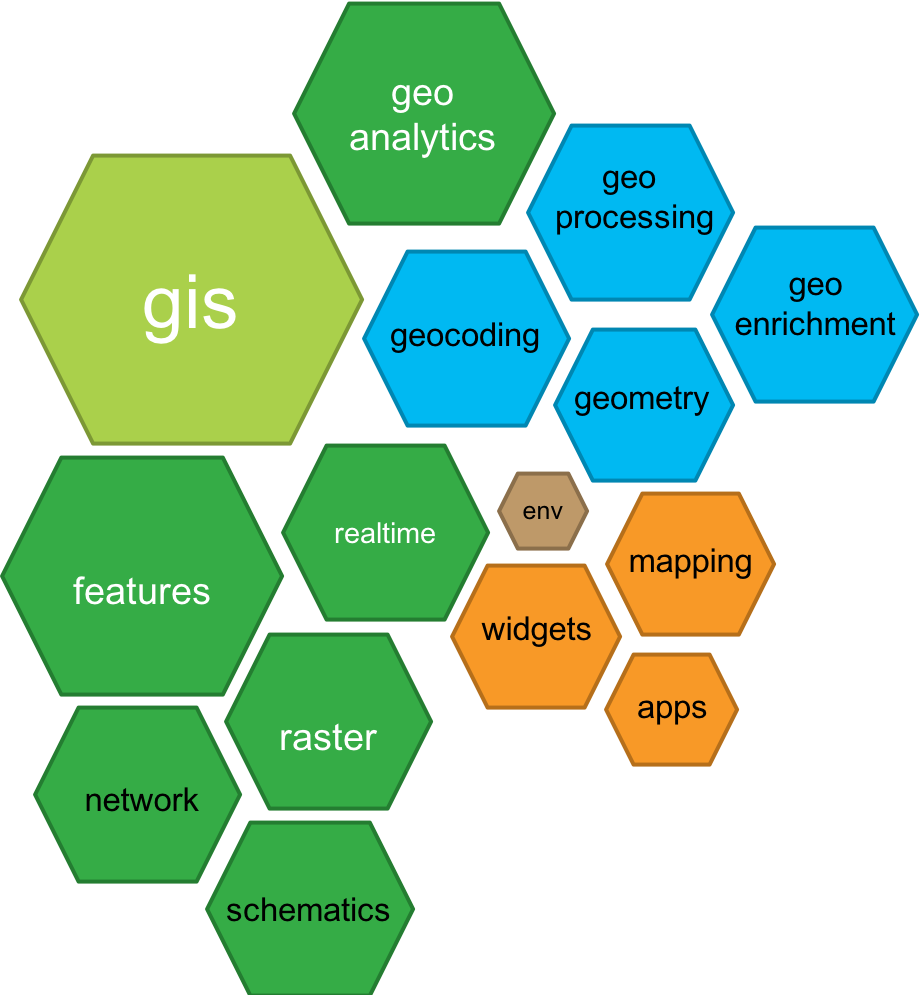

## The gis - module
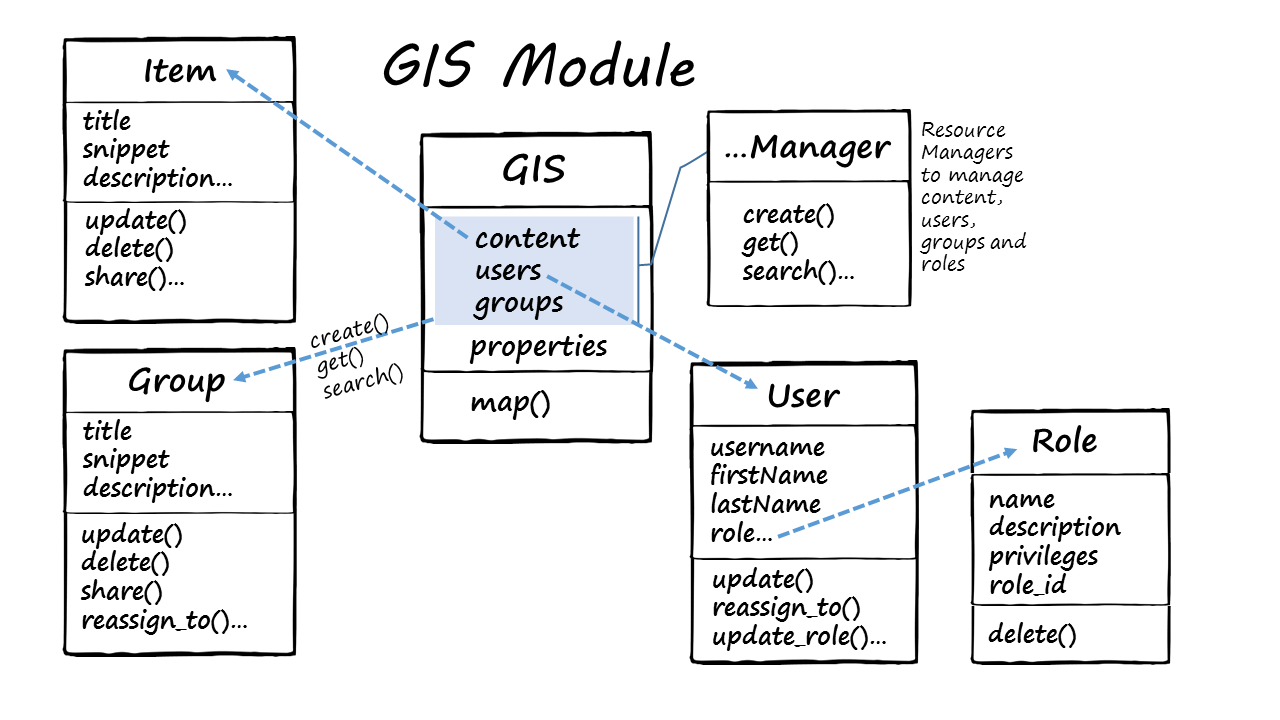

## Lets create a gis and use it

In [ ]:
# Connect to the Portal (Esri-Training)
from arcgis.gis import GIS
import getpass, webbrowser
from datetime import datetime as dt

agol_conn = GIS("https://www.arcgis.com",input('Adminusername: '), getpass.getpass('AdminPW: '))

## Use the users manager to query all users..

In [ ]:
# Query users via the 'users' manager
users = agol_conn.users.search(max_users=1000)
print("Total users found: {}".format(len(users)))

In [ ]:
# Display the users vs print the username
for user in users:
    display(user)

In [ ]:
for user in users:
    print(user.username)
    try:
        print(dt.fromtimestamp(user.lastLogin/1000))
    except:
        print('user never logged in')
    
   

## Identify the Top 10 storage wasters

In [ ]:
# Build a dict of all users and their storage usage
usageDict = {}
for user in users:
    usageDict[user.fullName] = round(user.storageUsage/1000000)
for item in usageDict:
    print(item, usageDict[item], "MB")

In [ ]:
# get top 10 storage users
topTen = 0
for user in sorted(usageDict,key=usageDict.get,reverse=True):

    if usageDict[user] > 0 and topTen < 10:
        print(user + "|" + str(usageDict[user])+"MB")
        topTen +=1

## Lets use the content manager

In [ ]:
# reference an item by its id (parcels in Berlin)
webbrowser.open("http://esri-de-5.maps.arcgis.com/home/item.html?id=bfb6c0cf9ac24433909eb49fe70abfdd")

parcel_item = agol_conn.content.get('bfb6c0cf9ac24433909eb49fe70abfdd')
display(parcel_item)
print(type(parcel_item))

## Inspect the item

In [ ]:
# Layers in the item
print(len(parcel_item.layers))

# title
print(parcel_item.title)

# owner
print(parcel_item.owner)

# description
print(parcel_item.snippet)


## Lets access the data

In [ ]:
# get the 'layer' item
parcel_layer = parcel_item.layers[0]
print(type(parcel_layer))

# query the data from the layer
# there are over 400.000 parcels in berlin. 
# we use a query filter to narrow down the results
parcel_data = parcel_layer.query('gemarkung_ = 0001 and amtlichefl > 50000')
print(type(parcel_data))


In [ ]:
# inspect the data
print('Number of parcels in Service: ',len(parcel_data.features))
print(parcel_data)

In [ ]:
# Access a certain attribute value
for parcel in parcel_data.features:
    print("Flurnummer", parcel.attributes['flur_numme'])

## And now for some more complex usage of the features & gis module...
Ben Hammersley, ladies & gentleman!

## Part 2: Bens Analysis Part

## Part 3: Preparing data for verification
+ the analysis result should now be verified by some fieldworkers using the collector app
+ each fieldworker has a certain area and should verify all points within
+ we will create:
  + one webmap per fieldworker with a defintion query
  + one user per fieldworker
  + one group per fieldworker
+ share the webmap to the group, add the fieldworker to the group

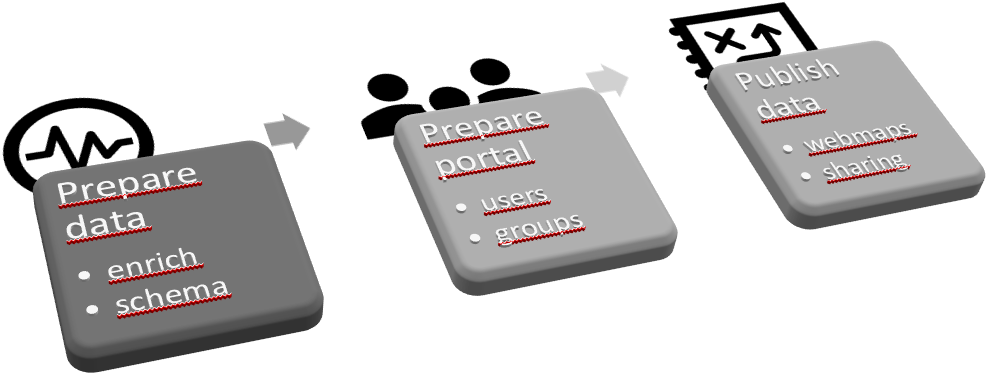

In [ ]:
# Task: Verifiy Point data with the collector through fieldworkers.
from arcgis.gis import GIS
from arcgis.features.analysis import join_features
import copy, json, arcgis, getpass, webbrowser

In [ ]:
# Connect to ArcGIS Enterprise
user = input("Enter Admin User: ")
pw = getpass.getpass("Enter Admin PW: ")
agol_conn = GIS("https://www.arcgis.com",user,pw)

In [ ]:
# Open AGOL and check data
webbrowser.open('http://esri-de-5.maps.arcgis.com/home/content.html?view=table&sortOrder=desc&sortField=modified&folder=540039b6f1bf48c48eed0654738cffff#content')

In [ ]:
# reference the two agol layers
fieldworkers_layer = agol_conn.content.get("bc889b93f59446f48fbe87e6e421e45c")
verify_points_layer = agol_conn.content.get("1cebaf029c5f450a9db93b3ea7c34c86")

In [ ]:
# copy Fieldworkers name from polygons to the underlying points
# Spatial Join
# arcgis.features.analysis.join_features(target_layer, join_layer, spatial_relationship=None, spatial_relationship_distance=None, spatial_relationship_distance_units=None, attribute_relationship=None, join_operation='JoinOneToOne', summary_fields=None, output_name=None, context=None, gis=None, estimate=False)
output_service = "points_for_fieldworkers_cambridge"
join_features(target_layer = verify_points_layer,join_layer = fieldworkers_layer, spatial_relationship = 'intersects', output_name = output_service)

# verify result
fieldworker_points_layer = agol_conn.content.search(output_service)[0]
display(fieldworker_points_layer)

In [ ]:
# Add a new field to the layer, with a domain
# Define the field
fieldinfo = {
           "name": "Verified",
           "type": "esriFieldTypeString",
           "alias": "Verified",
           "sqlType": "sqlTypeOther",
           "length": 255,
           "nullable": True,
           "editable": True,
           "domain":{
                "type": "codedValue",
                "name": "verified_domain",
                "codedValues": [
                  {
                    "name": "False",
                    "code": "False"
                  },
                  {
                    "name": "True",
                    "code": "True"
                  }
                ]
              },
           "defaultValue": None
         }

# use the layer manager to update the layers schema
layer = fieldworker_points_layer.layers[0]
update_dict = {"fields": [fieldinfo]}
layer.manager.add_to_definition(update_dict)

# set all rows to verified = false
layer.calculate(where= "1=1",calc_expression={"field": "Verified", "value": "False"})

# verify the result
display(fieldworker_points_layer)

In [ ]:
## Update the symbology of the layer from an already existing template layer

# Create a FeatureLayerCollection
from arcgis.features import FeatureLayerCollection
fieldworker_points_layer_flc = FeatureLayerCollection.fromitem(fieldworker_points_layer)
print(fieldworker_points_layer_flc.properties)

# Copy Symbology
symbology_layer = agol_conn.content.get('95f7b2a20ce54b589abd79bf1e253153').layers[0]
fieldworker_points_layer_flc.manager.update_definition({"drawingInfo": symbology_layer.properties['drawingInfo']})

# Enable Editing for the Fieldworkers layer
fieldworker_points_layer_flc.manager.update_definition({'hasStaticData': False })
fieldworker_points_layer_flc.manager.update_definition({'capabilities':'Query,Editing,Create,Update,Delete,Sync,Extract'})


In [ ]:
# Visualize result
map1 = agol_conn.map("Cambridge, UK")
map1.add_layer(fieldworker_points_layer)
display(map1)

In [ ]:
# create list with fieldworker name
namensliste = ["Fredrick Jimerson", "Sherilyn Mork","Gillian Hitz","Theo Heatherly"]

In [ ]:
# DEBUG 
userlist = []
grouplist = []
maplist = []

In [ ]:
# Per Fieldworker....
for name in namensliste:
    print(name)
    
    # Add a user
    user_obj = agol_conn.users.create(username = name.replace(" ",""),password = 'ChangeMe1234', firstname = name.split(" ")[0], lastname = name.split(" ")[1], email = '{}@testmail.de'.format(name.replace(" ","")))
        
    # Create a group
    group_obj = agol_conn.groups.create(title = "Collector Verification {}".format(name),tags = "DevSummit")
        
    # Add Member
    group_obj.add_users(user_obj.username)
    
    # Create a webmap
    wm = arcgis.mapping.WebMap()
    
    # Add the Point Layer
    wm.add_layer(fieldworker_points_layer)

    # Save the webmap
    web_map_properties = {'title':'Collector_data_{}'.format(name.replace(' ','')),
                     'snippet':'Map for the data verification with the collector app',
                     'tags':'collector, data verification'}
    wm_item = wm.save(item_properties=web_map_properties)
    
    ## Customize the WebMap
    # get the json from the webmap item
    wm_item_json = wm_item.get_data(try_json = True)
    
    #Make a deepcopy of the json to modify
    wm_json_deepcopy = copy.deepcopy(wm_item_json)
    
    # set layer filter with the name of the fieldworker
    lyrFilter = "Fieldworker_name = '{}'".format(name)
    wm_json_deepcopy['operationalLayers'][0]['layerDefinition']['definitionExpression'] = lyrFilter
    
    # Configure the popUp
    wm_json_deepcopy['operationalLayers'][0]['popupInfo']['title'] = 'Verify findings'
    field_infos = wm_json_deepcopy['operationalLayers'][0]['popupInfo']['fieldInfos']
    
    # Make the 'verified' field visible & editable
    for field in field_infos:
        if field['fieldName'] == 'Verified':
            field["visible"] = True
            field['label'] = 'Information verified?'
            field['isEditable'] = True 
        else:
    # Hide all other fields
            field['visible'] = False
            field['isEditable'] = False
               
    # Write the modified JSON back to the saved webmap
    wm_item.update(item_properties={'text':json.dumps(wm_json_deepcopy)})
    
    # Share webmap to the group
    wm_item.share(groups = [group_obj])
    
    # Done
    
    ## DEBUG: Save User Objects & Group Objects for removal
    grouplist.append(group_obj)
    userlist.append(user_obj)
    maplist.append(wm_item)

In [ ]:
# verifiy in AGOL
display(group_obj)

In [ ]:
for group in grouplist:
    try:
        group.delete()
    except:
        pass

In [ ]:
for user in userlist:
    try:
        user.delete()
    except:
        pass
    
    

In [ ]:
for webMap in maplist:
    try:
        webMap.delete()
    except:
        pass

## Part 4: Outlook & Finish

... back to Ben!